# Time Series Analysis of Industrial Production: Mining (1919-2025)


## Introduction

This notebook analyzes the Industrial Production Index for Mining (IPMINE) from the Federal Reserve Economic Data (FRED). This economic indicator measures the real output of the mining sector, including oil and gas extraction, and serves as a key indicator of resource extraction activity in the US economy.

---

In [1]:
# Install required packages if needed
# install.packages(c("ggplot2", "forecast", "TSA", "tseries", "dplyr",
#                   "lubridate", "gridExtra", "MASS", "knitr", "lawstat",
#                   "FinTS", "ggthemes"))


In [2]:
suppressPackageStartupMessages({
  library(ggplot2)
  library(forecast)
  library(tseries)
  library(dplyr)
  library(lubridate)
  library(gridExtra)
  library(MASS)
  library(knitr)
  library(lawstat)
  library(FinTS)
  library(TSA)
})


In [3]:
# Plot settings
options(repr.plot.width = 20, repr.plot.height = 10)
theme_tsa <- function() {
  theme_minimal() +
    theme(
      plot.title = element_text(hjust = 0.5, face = "bold", size = 14),
      plot.subtitle = element_text(hjust = 0.5, size = 12),
      axis.title = element_text(face = "bold"),
      legend.position = "bottom",
      panel.grid.minor = element_line(color = "gray90"),
      panel.grid.major = element_line(color = "gray85")
    )
}

In [4]:
# loading the data and checking it for missing values
# and summary statistics, then printing the results

mining_df <- read.csv("../data/mining_production.csv")
mining_df$date <- as.Date(mining_df$date)
names(mining_df)[names(mining_df) == "value"] <- "index"

cat("Dataset summary:\n")
print(summary(mining_df))

cat(
    "\nDate range:", format(min(mining_df$date), "%Y-%m-%d"),
    "to", format(max(mining_df$date), "%Y-%m-%d"), "\n"
)

cat(
    "Index range:", min(mining_df$index),
    "to", max(mining_df$index), "\n"
)

missing_values <- colSums(is.na(mining_df))
cat("\nMissing values by column:\n")
print(missing_values)

Dataset summary:
      date                index      
 Min.   :1919-01-01   Min.   :15.87  
 1st Qu.:1939-03-24   1st Qu.:35.63  
 Median :1959-06-16   Median :64.40  
 Mean   :1959-06-16   Mean   :61.29  
 3rd Qu.:1979-09-08   3rd Qu.:85.31  
 Max.   :1999-12-01   Max.   :99.11  

Date range: 1919-01-01 to 1999-12-01 
Index range: 15.8683 to 99.1148 

Missing values by column:
 date index 
    0     0 


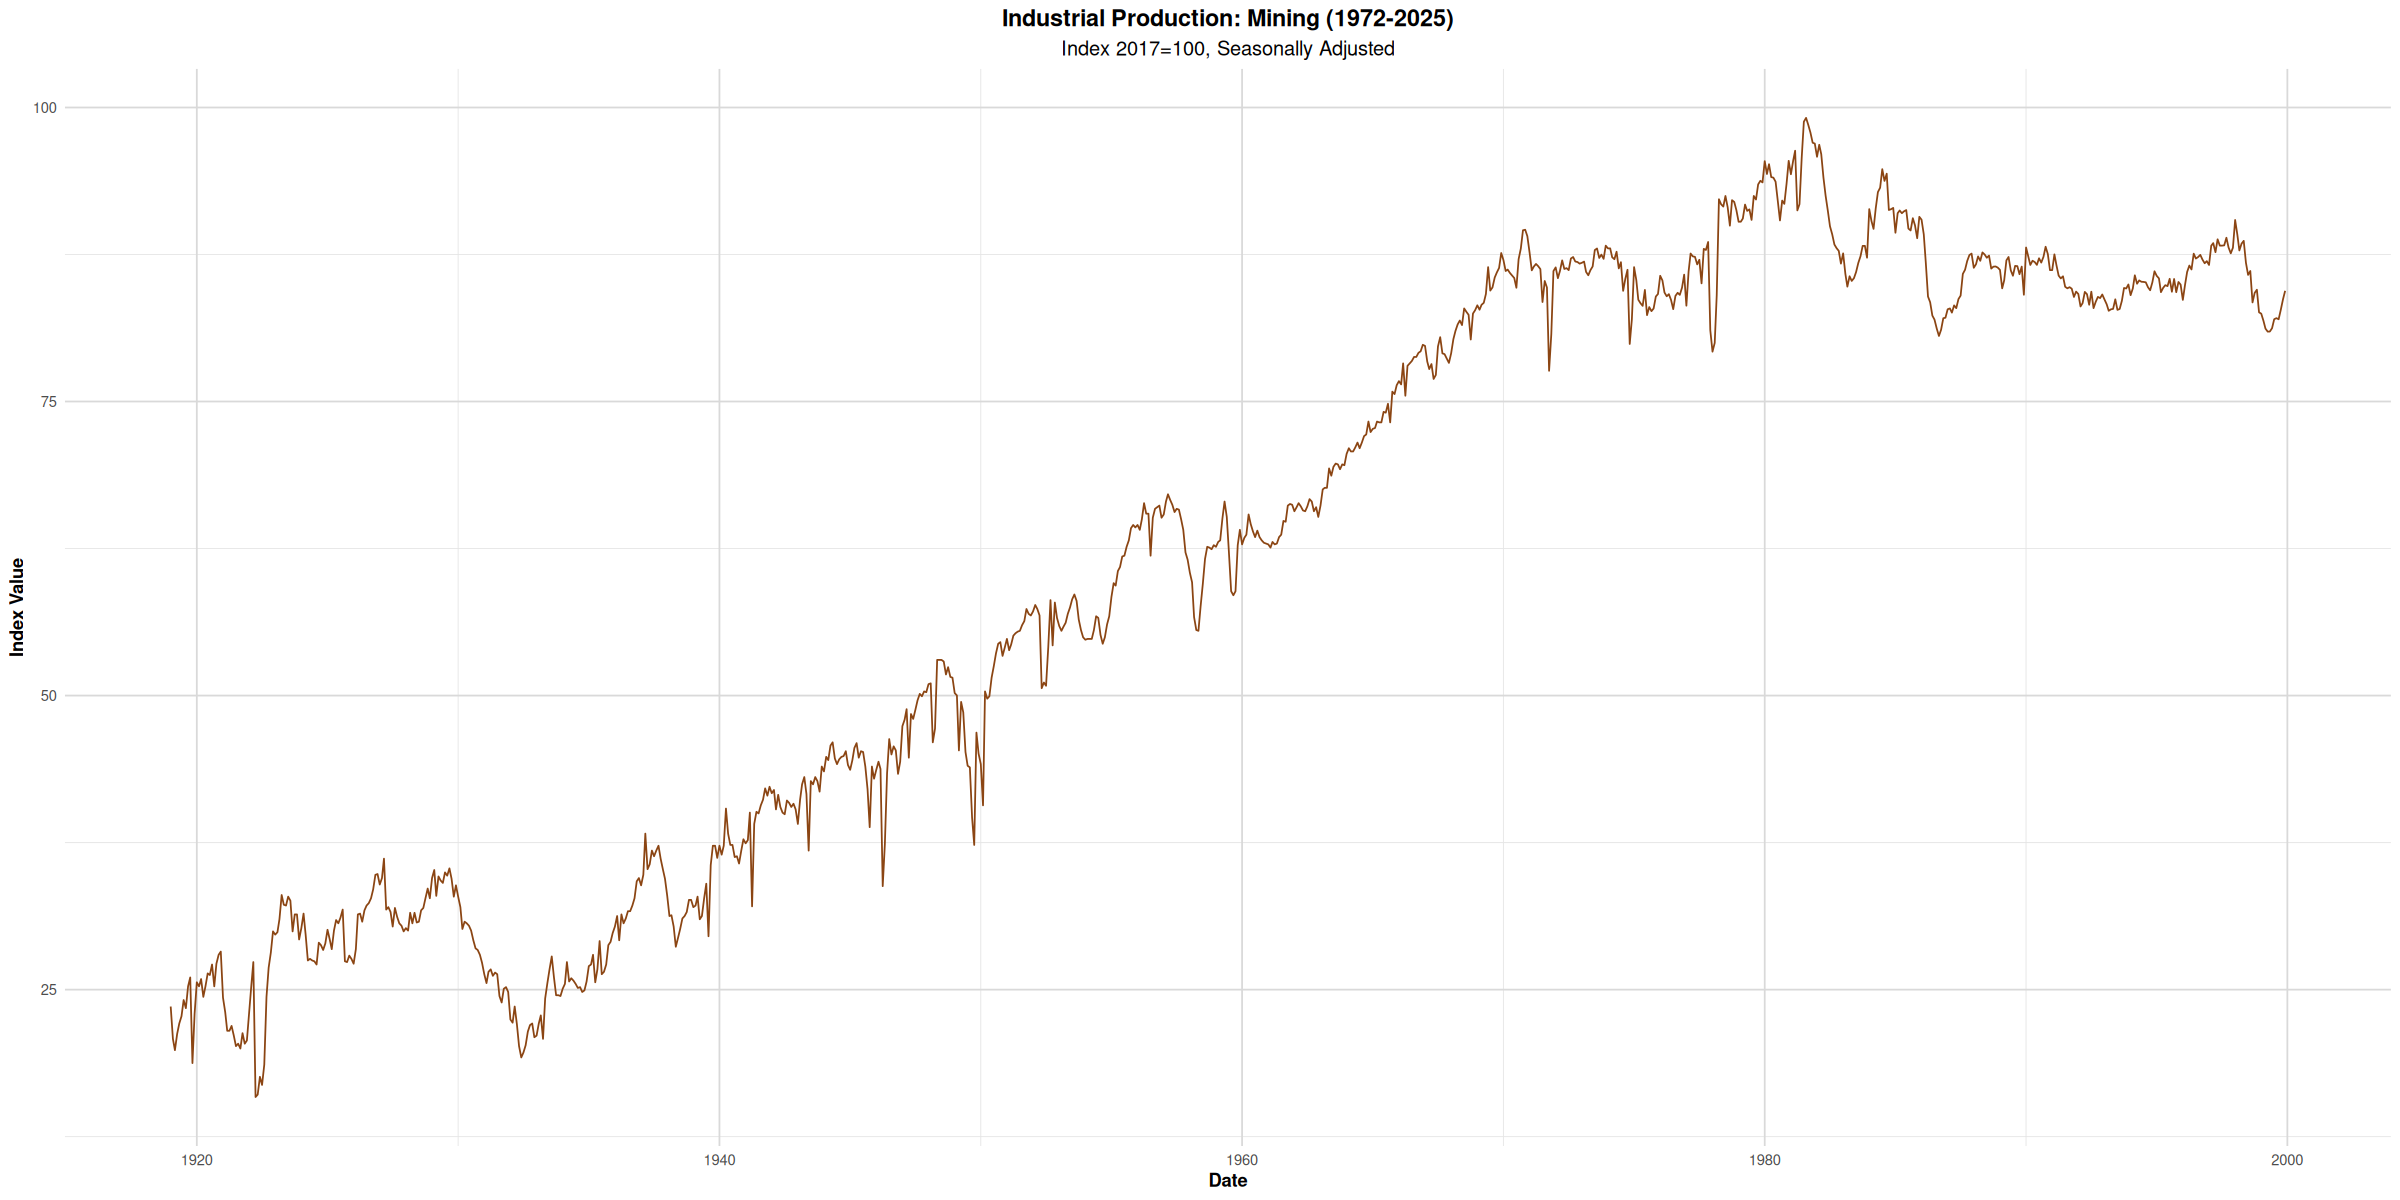

In [5]:
# plot the series

p1 <- ggplot(mining_df, aes(x = date, y = index)) +
  geom_line(color = "#8B4513") +
  labs(
    title = "Industrial Production: Mining (1972-2025)",
    subtitle = "Index 2017=100, Seasonally Adjusted",
    x = "Date",
    y = "Index Value"
  ) +
  theme_tsa()

print(p1)

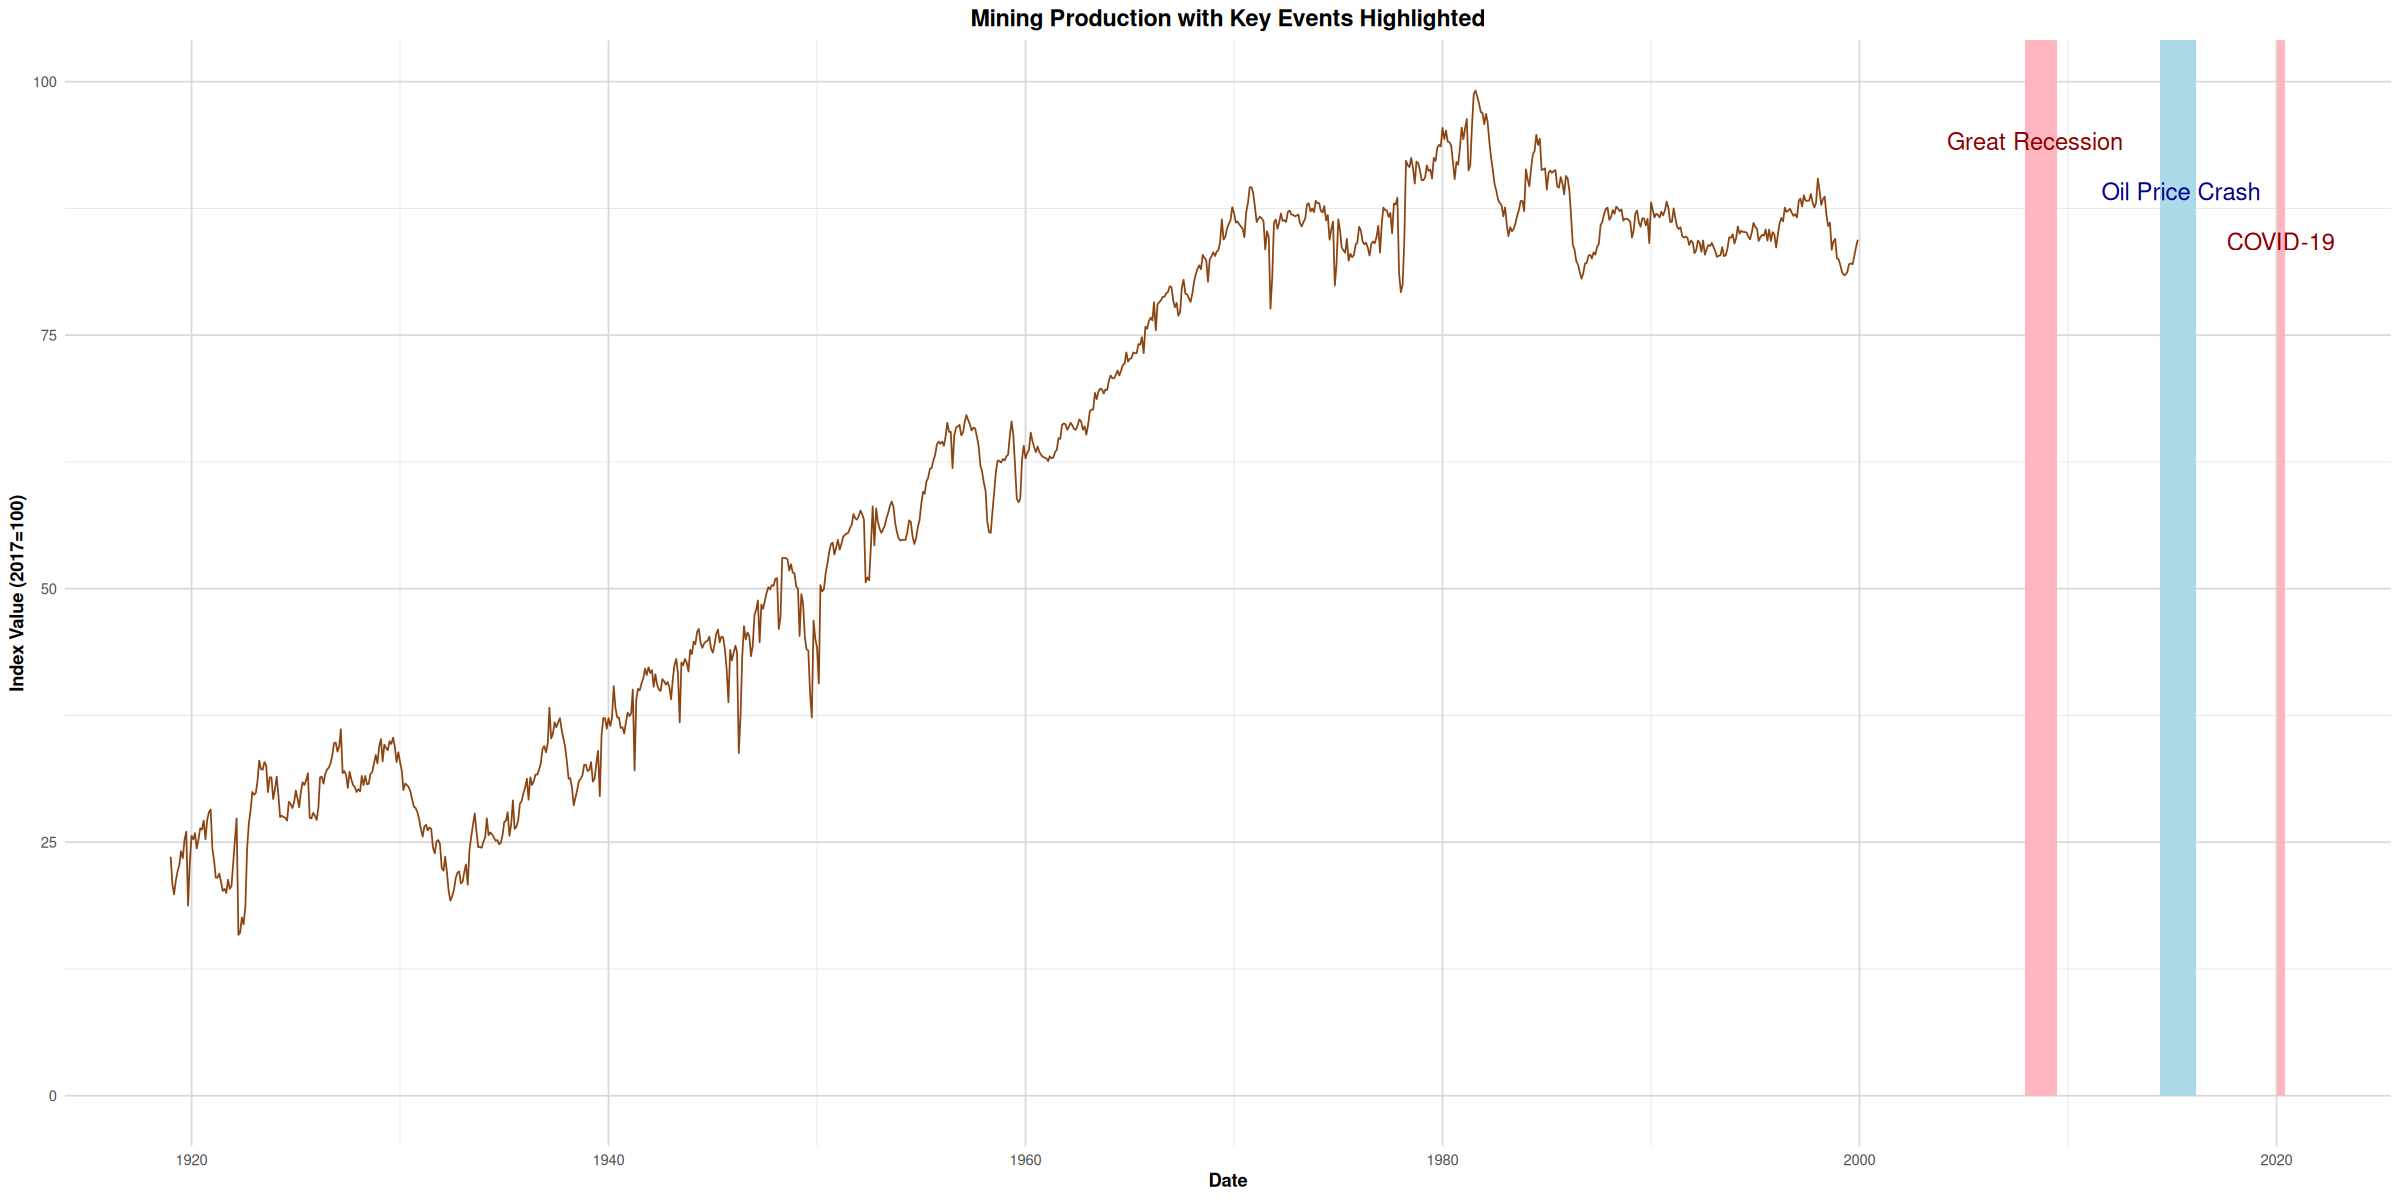

In [6]:
# Highlight key events affecting mining sector
p2 <- ggplot(mining_df, aes(x = date, y = index)) +
  geom_line(color = "#8B4513") +
  geom_rect(
    aes(
      xmin = as.Date("2007-12-01"),
      xmax = as.Date("2009-06-30"),
      ymin = 0,
      ymax = Inf
    ),
    fill = "lightpink", alpha = 0.2
  ) +
  geom_rect(
    aes(
      xmin = as.Date("2014-06-01"),
      xmax = as.Date("2016-02-28"),
      ymin = 0,
      ymax = Inf
    ),
    fill = "lightblue", alpha = 0.2
  ) +
  geom_rect(
    aes(
      xmin = as.Date("2020-01-01"),
      xmax = as.Date("2020-05-31"),
      ymin = 0,
      ymax = Inf
    ),
    fill = "lightpink", alpha = 0.2
  ) +
  annotate("text",
    x = as.Date("2008-06-01"), y = max(mining_df$index) * 0.95,
    label = "Great Recession", color = "darkred", size = 5
  ) +
  annotate("text",
    x = as.Date("2015-06-01"), y = max(mining_df$index) * 0.9,
    label = "Oil Price Crash", color = "darkblue", size = 5
  ) +
  annotate("text",
    x = as.Date("2020-03-15"), y = max(mining_df$index) * 0.85,
    label = "COVID-19", color = "darkred", size = 5
  ) +
  labs(
    title = "Mining Production with Key Events Highlighted",
    x = "Date",
    y = "Index Value (2017=100)"
  ) +
  theme_tsa()

print(p2)

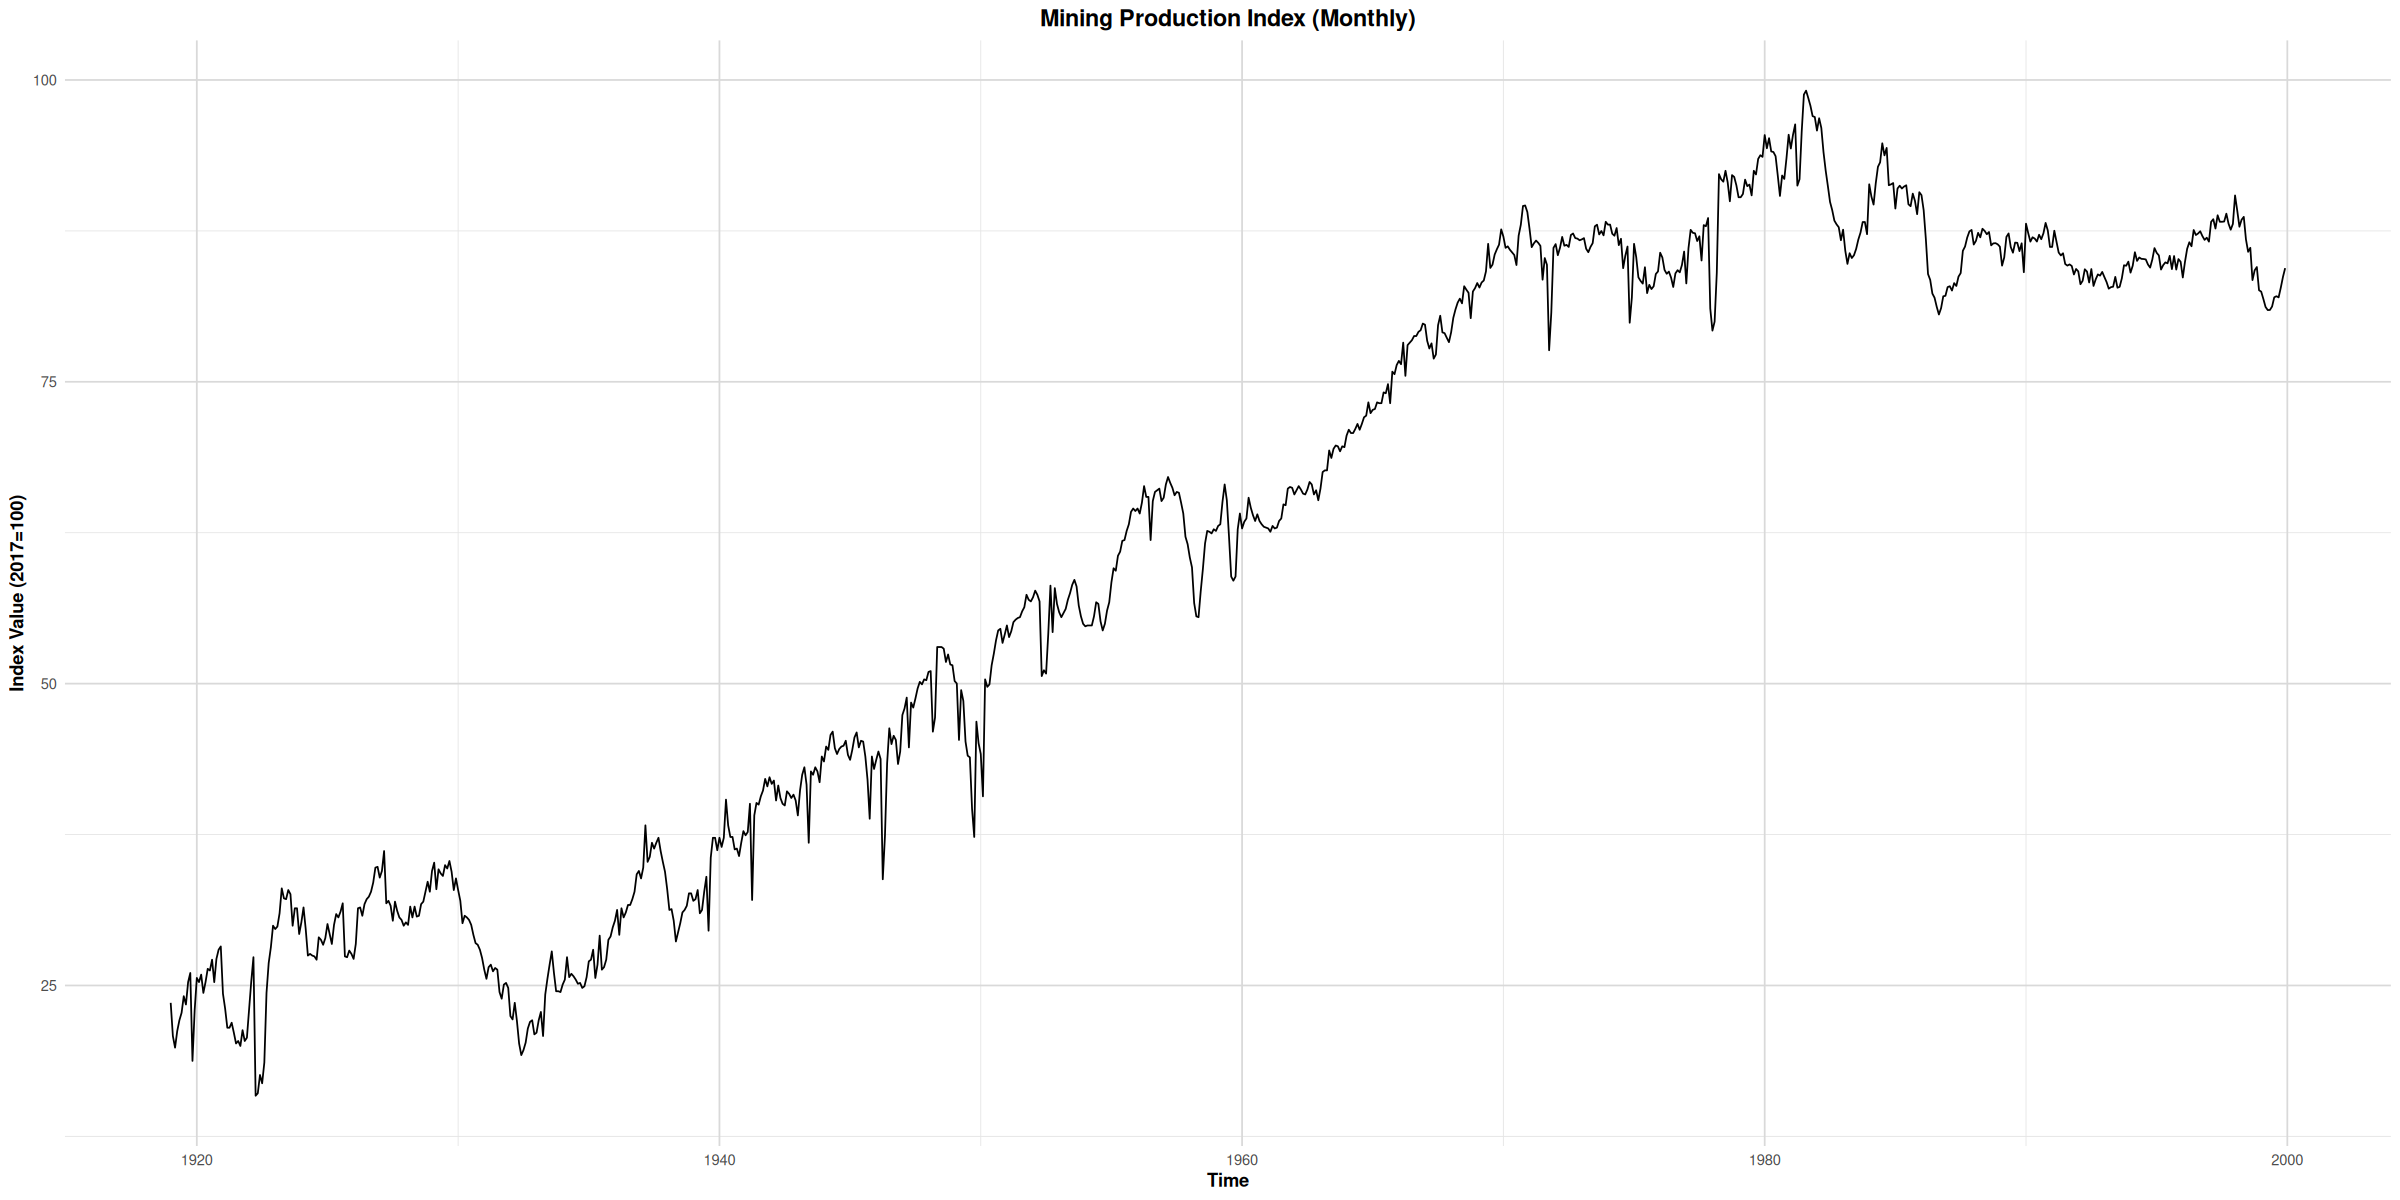

In [7]:
# Create a monthly time series object
monthly_ts <- ts(mining_df$index,
  frequency = 12,
  start = c(
    year(min(mining_df$date)),
    month(min(mining_df$date))
  )
)

# Plot the time series
autoplot(monthly_ts) +
  labs(
    title = "Mining Production Index (Monthly)",
    x = "Time",
    y = "Index Value (2017=100)"
  ) +
  theme_tsa()

Optimal lambda for Box-Cox transformation: 1.085881 
Lambda is close to 1, no transformation needed


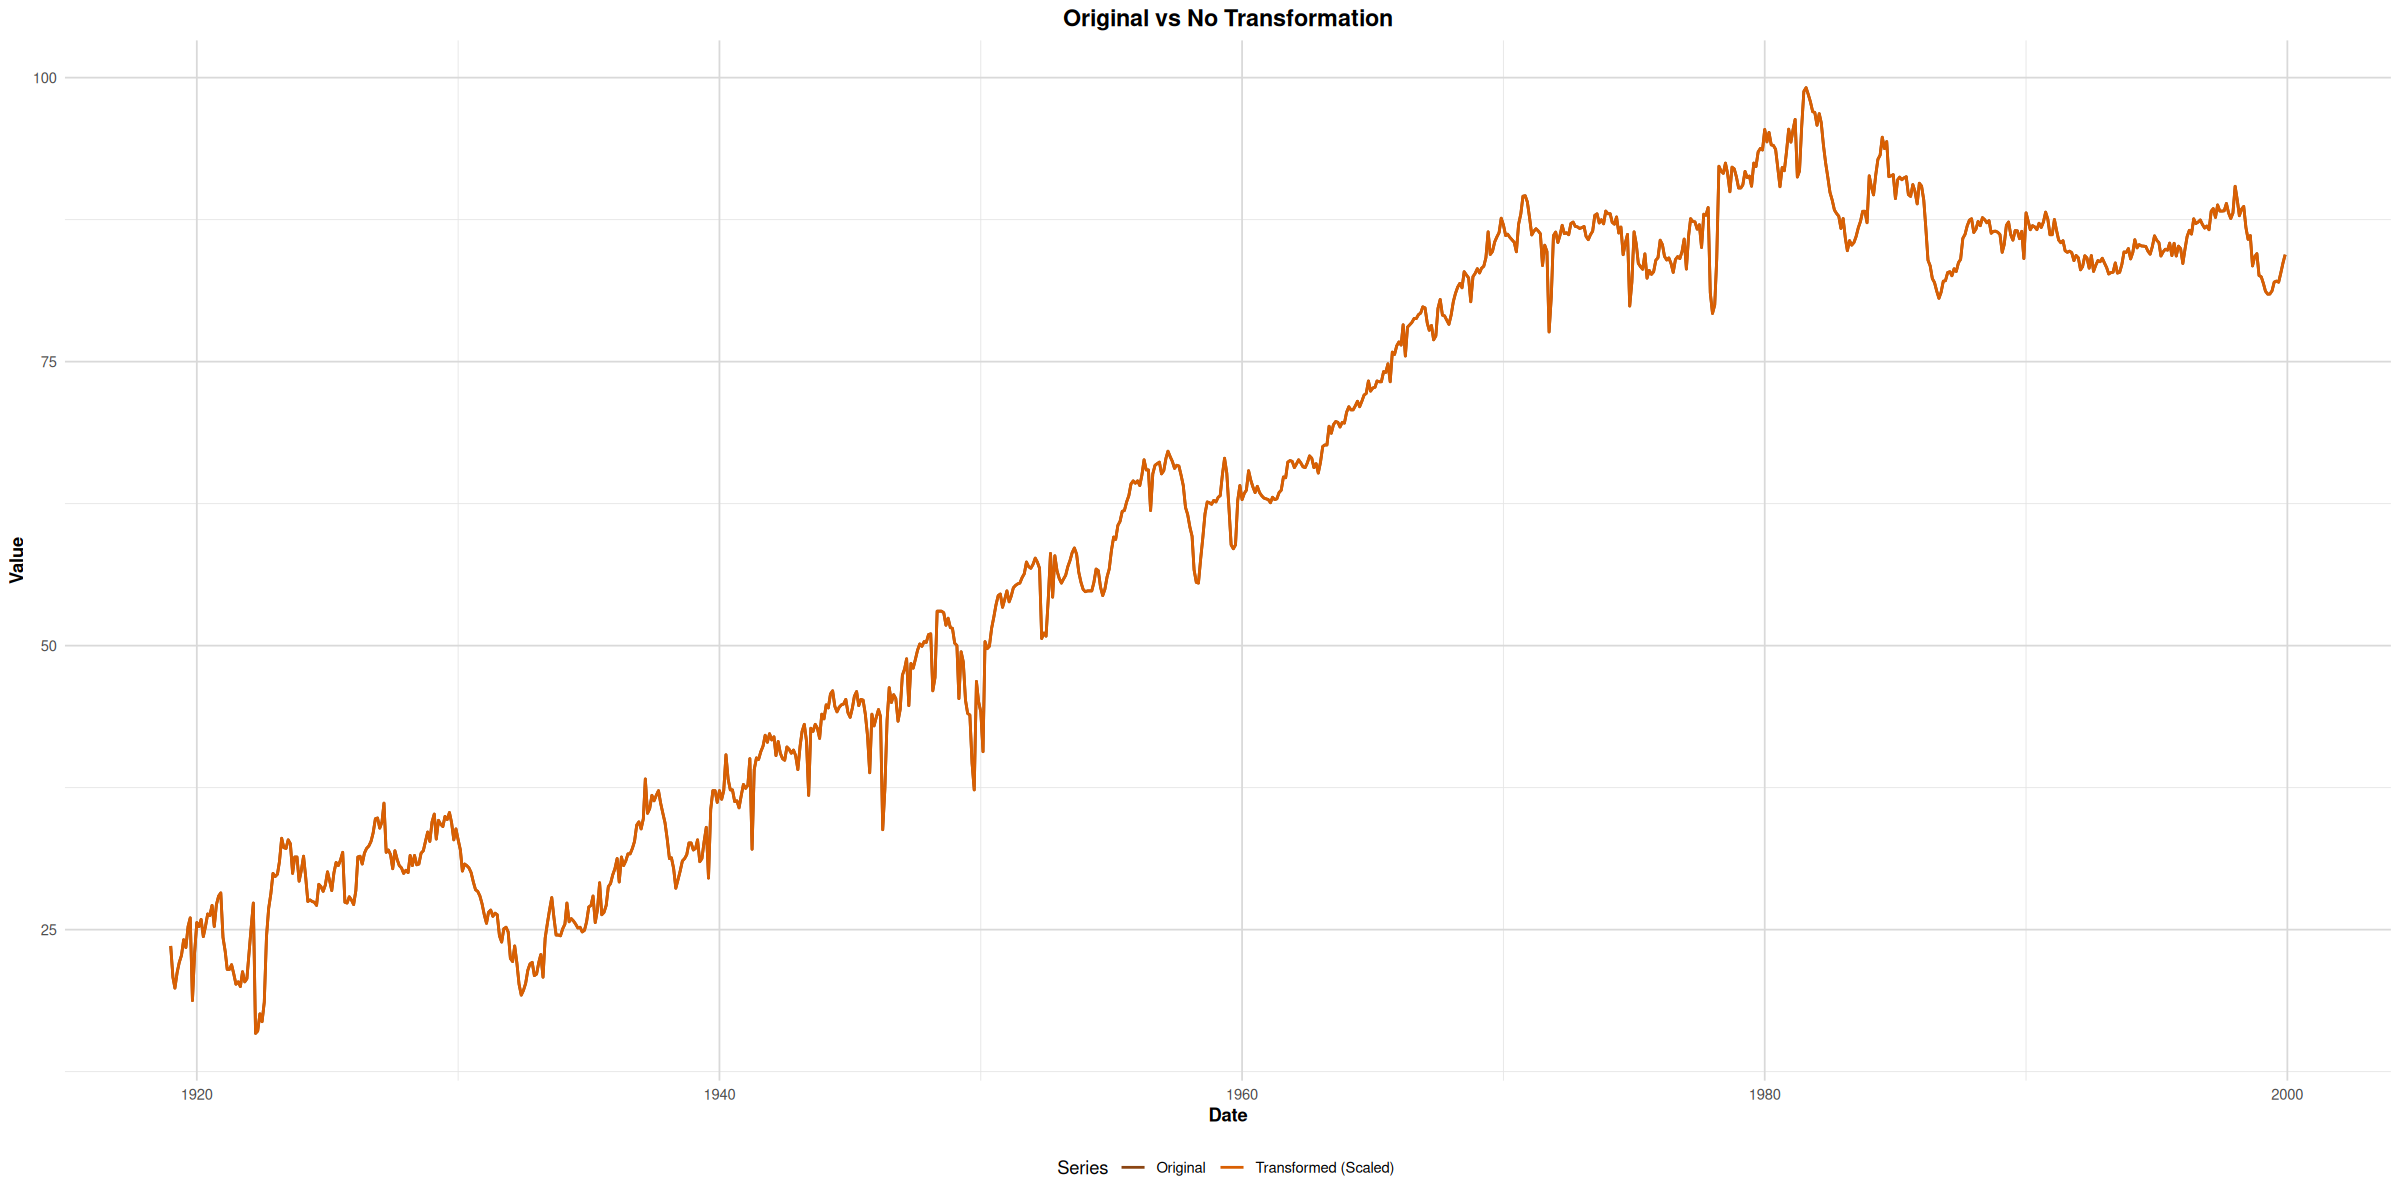

In [8]:
# box-cox transformation

lambda <- BoxCox.lambda(monthly_ts)
cat("Optimal lambda for Box-Cox transformation:", lambda, "\n")
if (abs(lambda) < 0.1) {
    cat("Lambda is close to 0, using log transformation\n")
    transformed_ts <- log(monthly_ts)
    transformation_label <- "Log Transformation"
} else if (abs(lambda - 1) < 0.1) {
    cat("Lambda is close to 1, no transformation needed\n")
    transformed_ts <- monthly_ts
    transformation_label <- "No Transformation"
} else if (lambda == 0) {
    cat("Lambda is 0, using log transformation\n")
    transformed_ts <- log(monthly_ts)
    transformation_label <- "Log Transformation"
} else {
    cat("Using Box-Cox transformation with lambda =", lambda, "\n")
    transformed_ts <- BoxCox(monthly_ts, lambda)
    transformation_label <- paste("Box-Cox Transformation (λ =", round(lambda, 4), ")")
}

transformed_df <- data.frame(
    Date = mining_df$date,
    Original = as.numeric(monthly_ts),
    Transformed = as.numeric(transformed_ts)
)

p_trans <- ggplot(transformed_df, aes(x = Date)) +
    geom_line(aes(y = Original, color = "Original"), linewidth = 0.8) +
    geom_line(aes(
        y = scale(Transformed) * sd(Original) + mean(Original),
        color = "Transformed (Scaled)"
    ), linewidth = 0.8) +
    labs(
        title = paste("Original vs", transformation_label),
        x = "Date", y = "Value",
        color = "Series"
    ) +
    scale_color_manual(values = c("Original" = "#8B4513", "Transformed (Scaled)" = "#D95F02")) +
    theme_tsa()

print(p_trans)


In [9]:
# test for stationarity using ADF test and KPSS test

adf_test <- adf.test(transformed_ts, alternative = "stationary")
kpss_test <- kpss.test(transformed_ts, null = "Trend")

cat("ADF Test for Stationarity:\n")
print(adf_test)

cat("\nKPSS Test for Stationarity:\n")
print(kpss_test)

cat("\nConclusion:\n")
if (adf_test$p.value < 0.05) {
    cat("ADF test rejects the null hypothesis, series is stationary\n")
} else {
    cat("ADF test fails to reject the null hypothesis, series is non-stationary\n")
}
if (kpss_test$p.value < 0.05) {
    cat("KPSS test rejects the null hypothesis, series is non-stationary\n")
} else {
    cat("KPSS test fails to reject the null hypothesis, series is stationary\n")
}

Warning message in kpss.test(transformed_ts, null = "Trend"):
“p-value smaller than printed p-value”


ADF Test for Stationarity:

	Augmented Dickey-Fuller Test

data:  transformed_ts
Dickey-Fuller = -1.8288, Lag order = 9, p-value = 0.6508
alternative hypothesis: stationary


KPSS Test for Stationarity:

	KPSS Test for Trend Stationarity

data:  transformed_ts
KPSS Trend = 1.6003, Truncation lag parameter = 7, p-value = 0.01


Conclusion:
ADF test fails to reject the null hypothesis, series is non-stationary
KPSS test rejects the null hypothesis, series is non-stationary


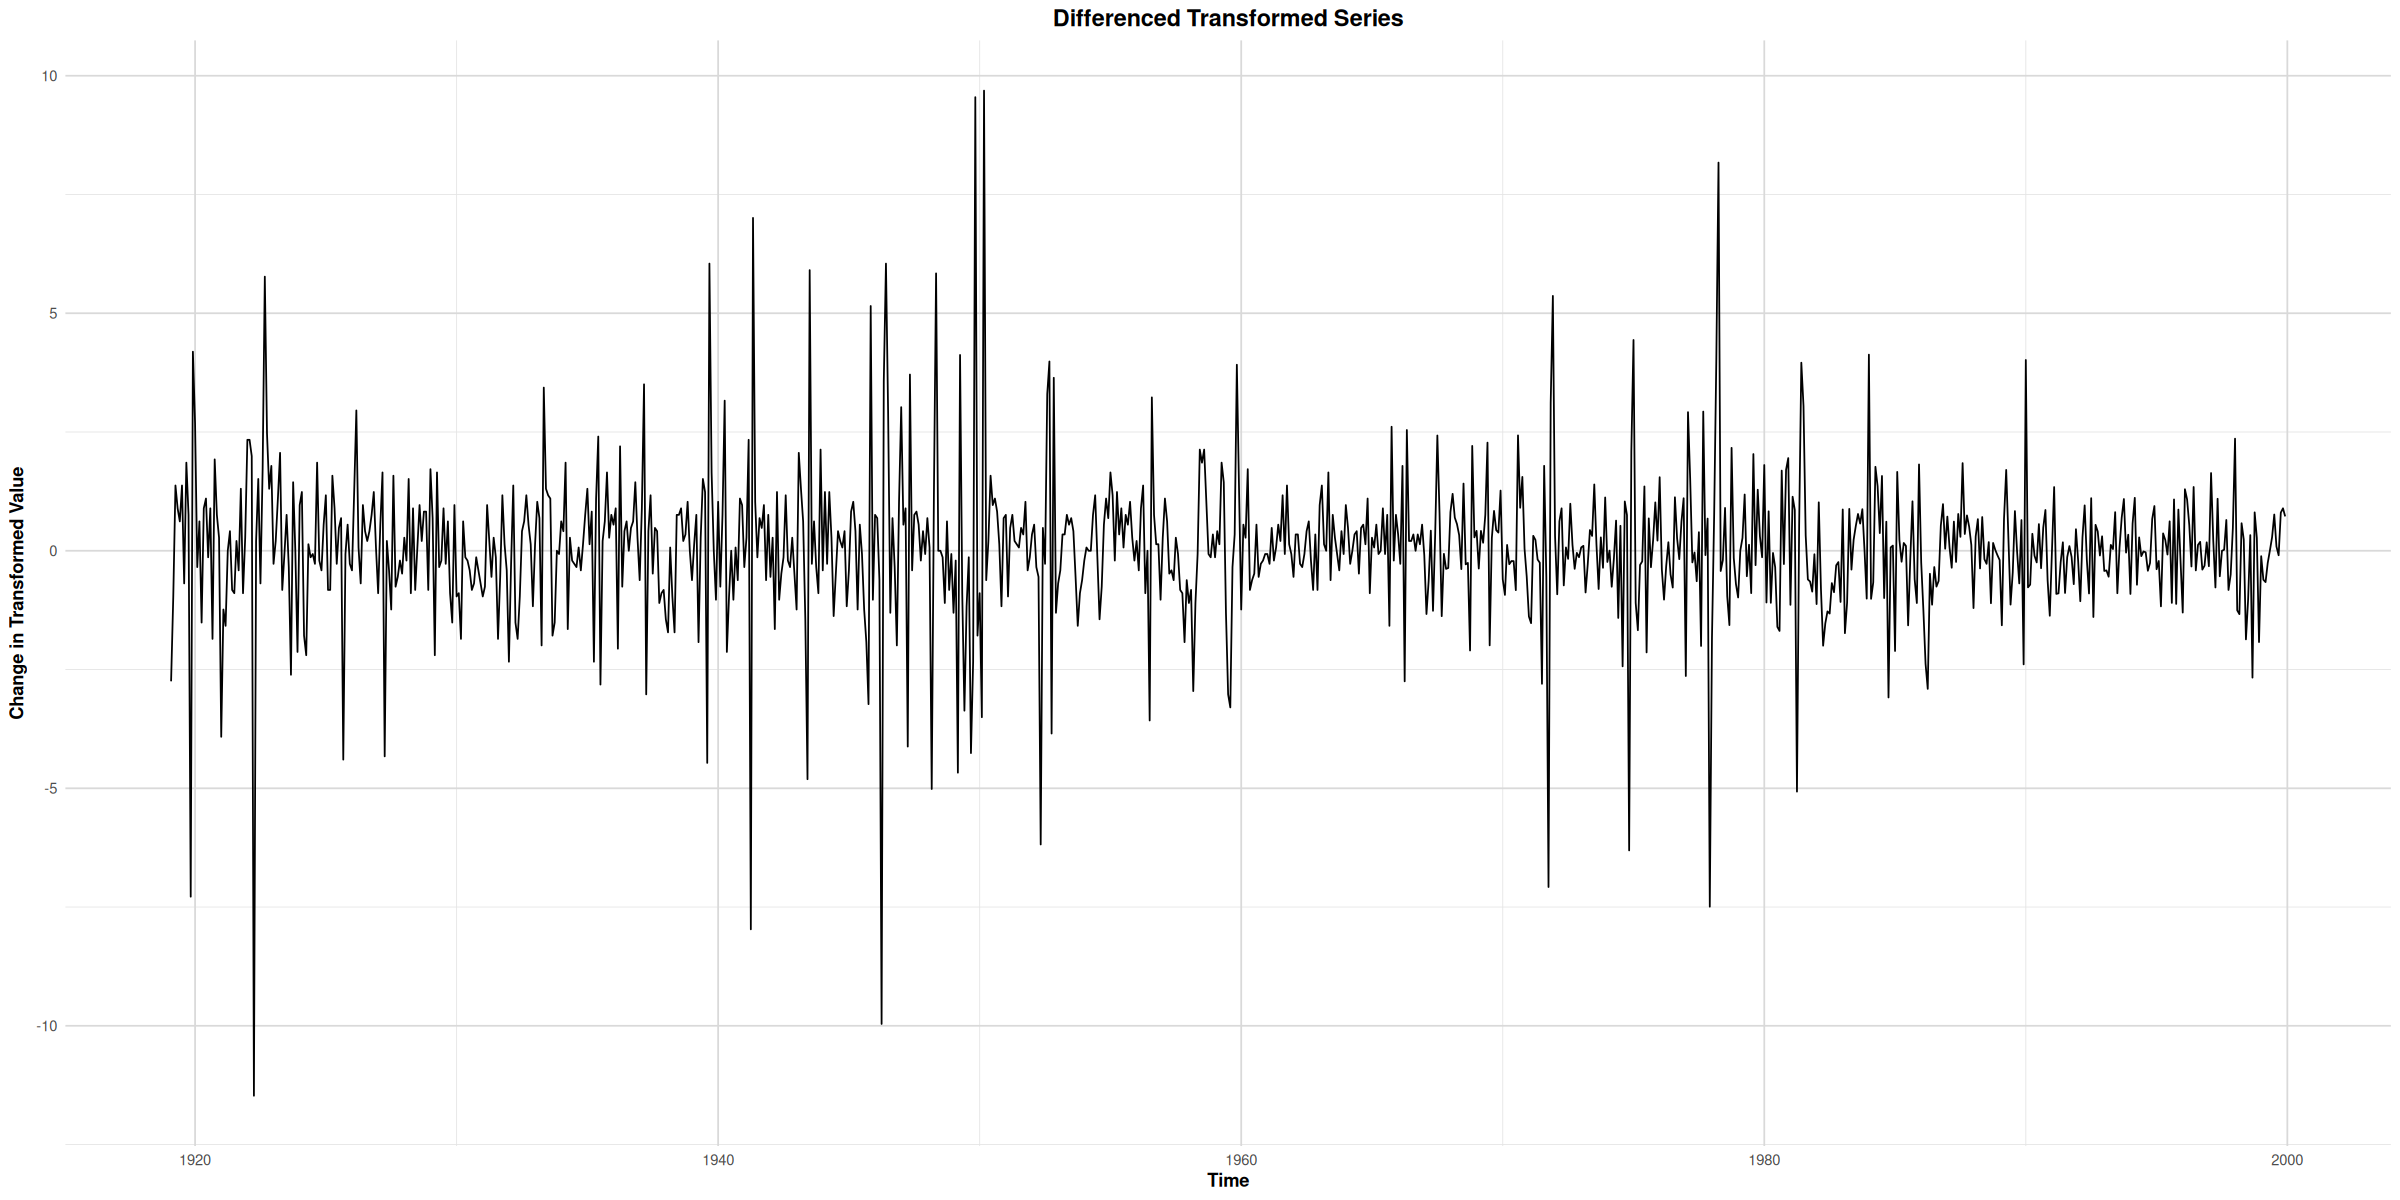

In [10]:
# differencing the series to make it stationary

diff_ts <- diff(transformed_ts)

p_diff <- autoplot(diff_ts) +
    labs(
        title = "Differenced Transformed Series",
        x = "Time", y = "Change in Transformed Value"
    ) +
    theme_tsa()

print(p_diff)

In [11]:
# retesting for stationarity after differencing

adf_test_diff <- adf.test(diff_ts, alternative = "stationary")
kpss_test_diff <- kpss.test(diff_ts, null = "Trend")

cat("ADF Test for Stationarity (After Differencing):\n")
print(adf_test_diff)

cat("\nKPSS Test for Stationarity (After Differencing):\n")
print(kpss_test_diff)

cat("\nConclusion (After Differencing):\n")
if (adf_test_diff$p.value < 0.05) {
    cat("ADF test rejects the null hypothesis, series is stationary\n")
} else {
    cat("ADF test fails to reject the null hypothesis, series is non-stationary\n")
}
if (kpss_test_diff$p.value < 0.05) {
    cat("KPSS test rejects the null hypothesis, series is non-stationary\n")
} else {
    cat("KPSS test fails to reject the null hypothesis, series is stationary\n")
}

Warning message in adf.test(diff_ts, alternative = "stationary"):
“p-value smaller than printed p-value”
Warning message in kpss.test(diff_ts, null = "Trend"):
“p-value greater than printed p-value”


ADF Test for Stationarity (After Differencing):

	Augmented Dickey-Fuller Test

data:  diff_ts
Dickey-Fuller = -10.649, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary


KPSS Test for Stationarity (After Differencing):

	KPSS Test for Trend Stationarity

data:  diff_ts
KPSS Trend = 0.054387, Truncation lag parameter = 7, p-value = 0.1


Conclusion (After Differencing):
ADF test rejects the null hypothesis, series is stationary
KPSS test fails to reject the null hypothesis, series is stationary


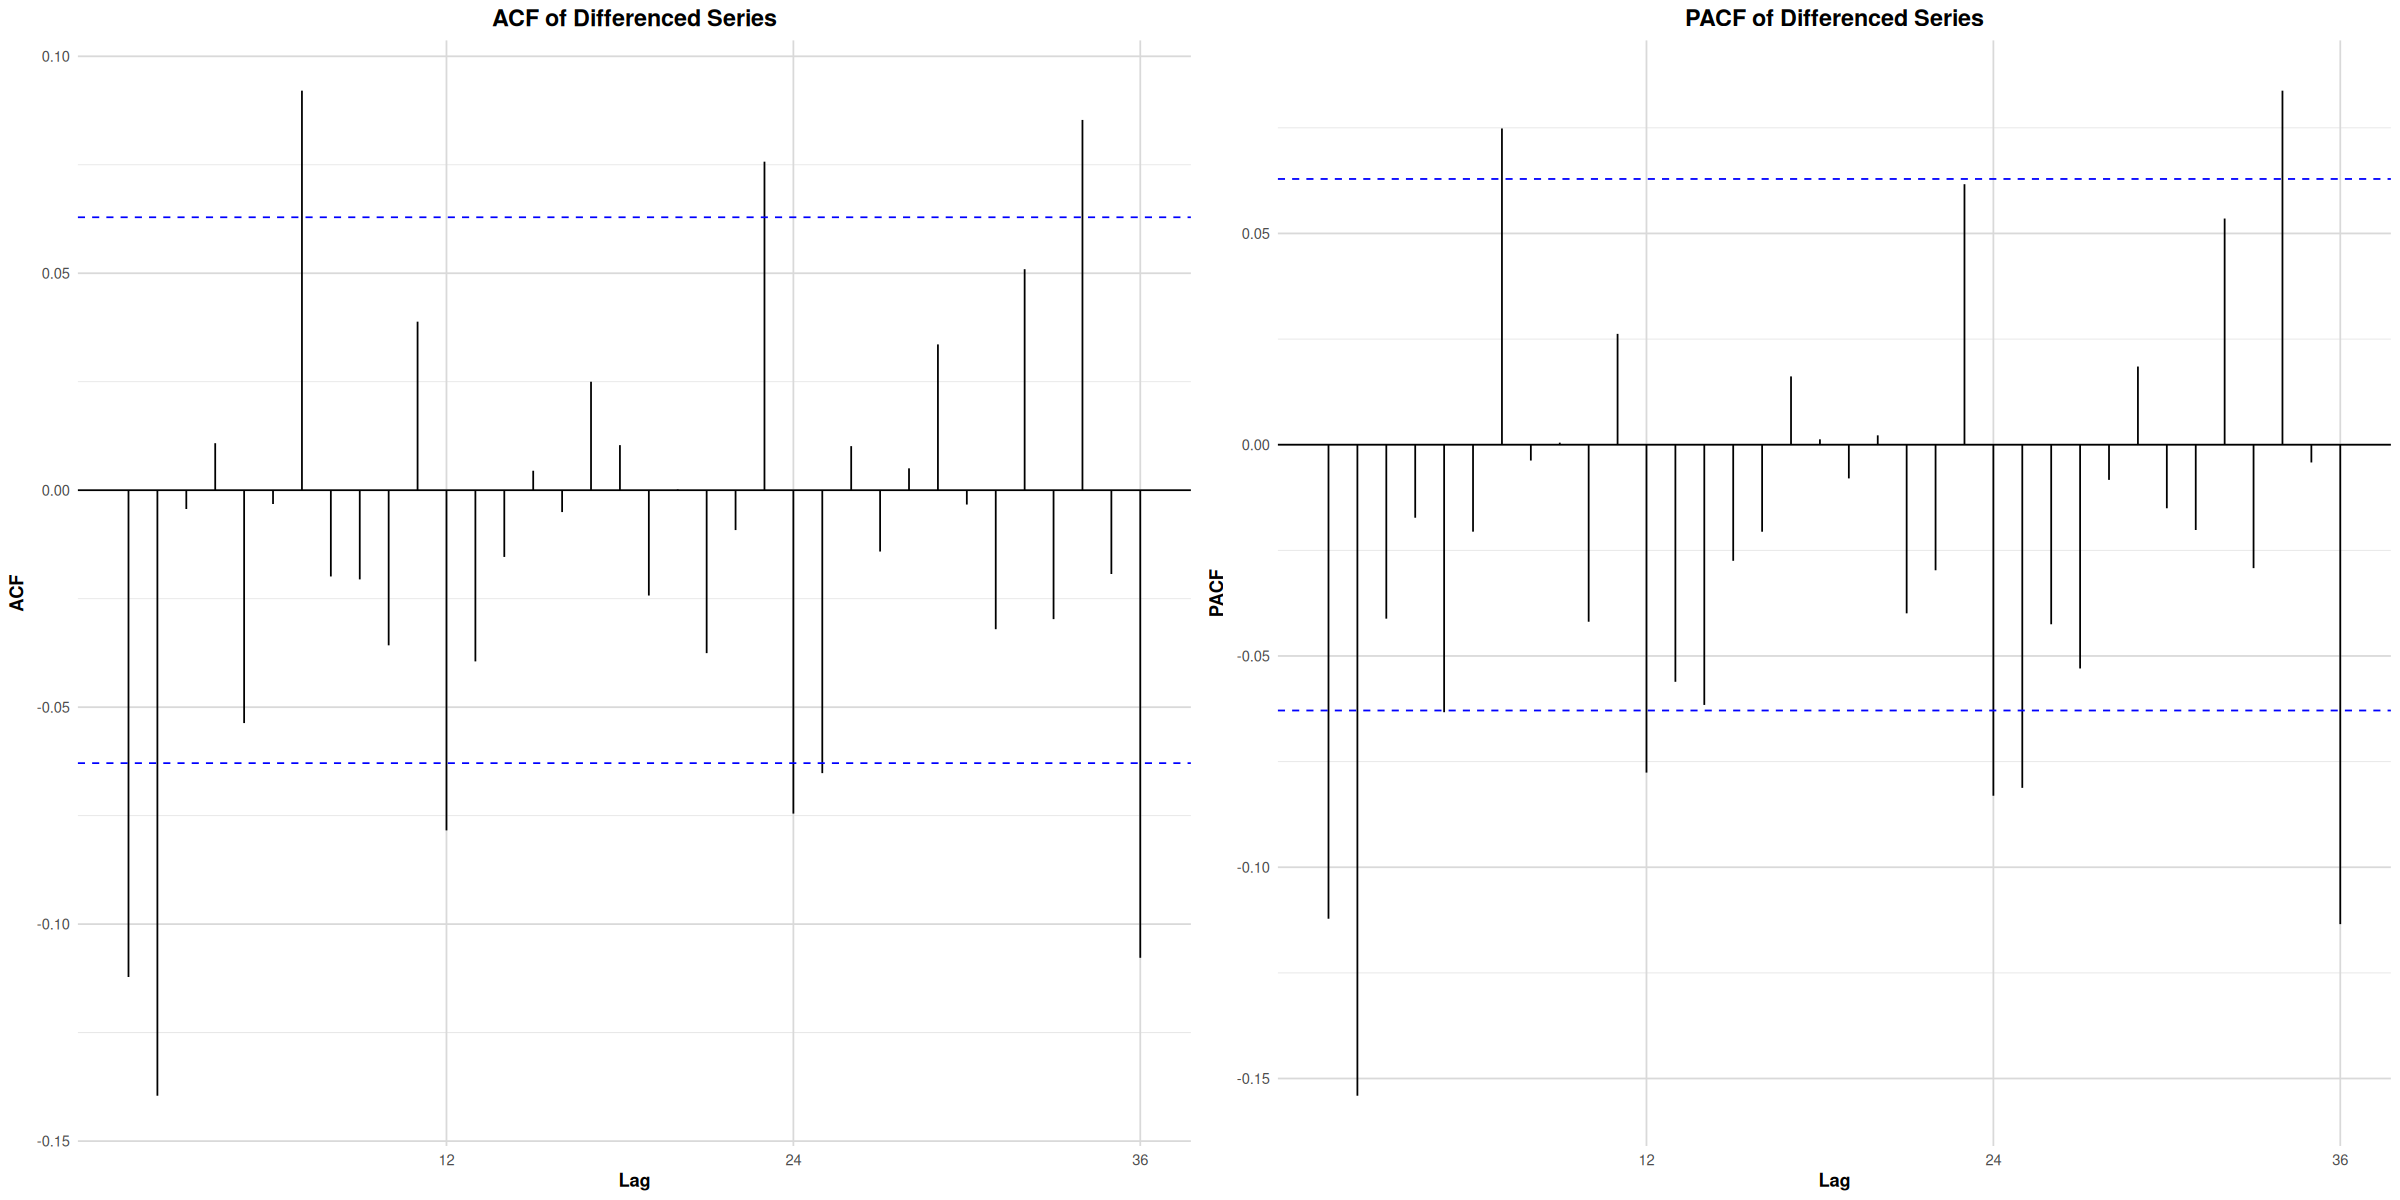

In [12]:
# ACF and PACF plots for differenced series

p_acf_diff <- ggAcf(diff_ts, lag = 36) +
    labs(
        title = "ACF of Differenced Series",
        x = "Lag", y = "ACF"
    ) +
    theme_tsa()

p_pacf_diff <- ggAcf(diff_ts, lag = 36, type = "partial") +
    labs(
        title = "PACF of Differenced Series",
        x = "Lag", y = "PACF"
    ) +
    theme_tsa()

grid.arrange(p_acf_diff, p_pacf_diff, ncol = 2)

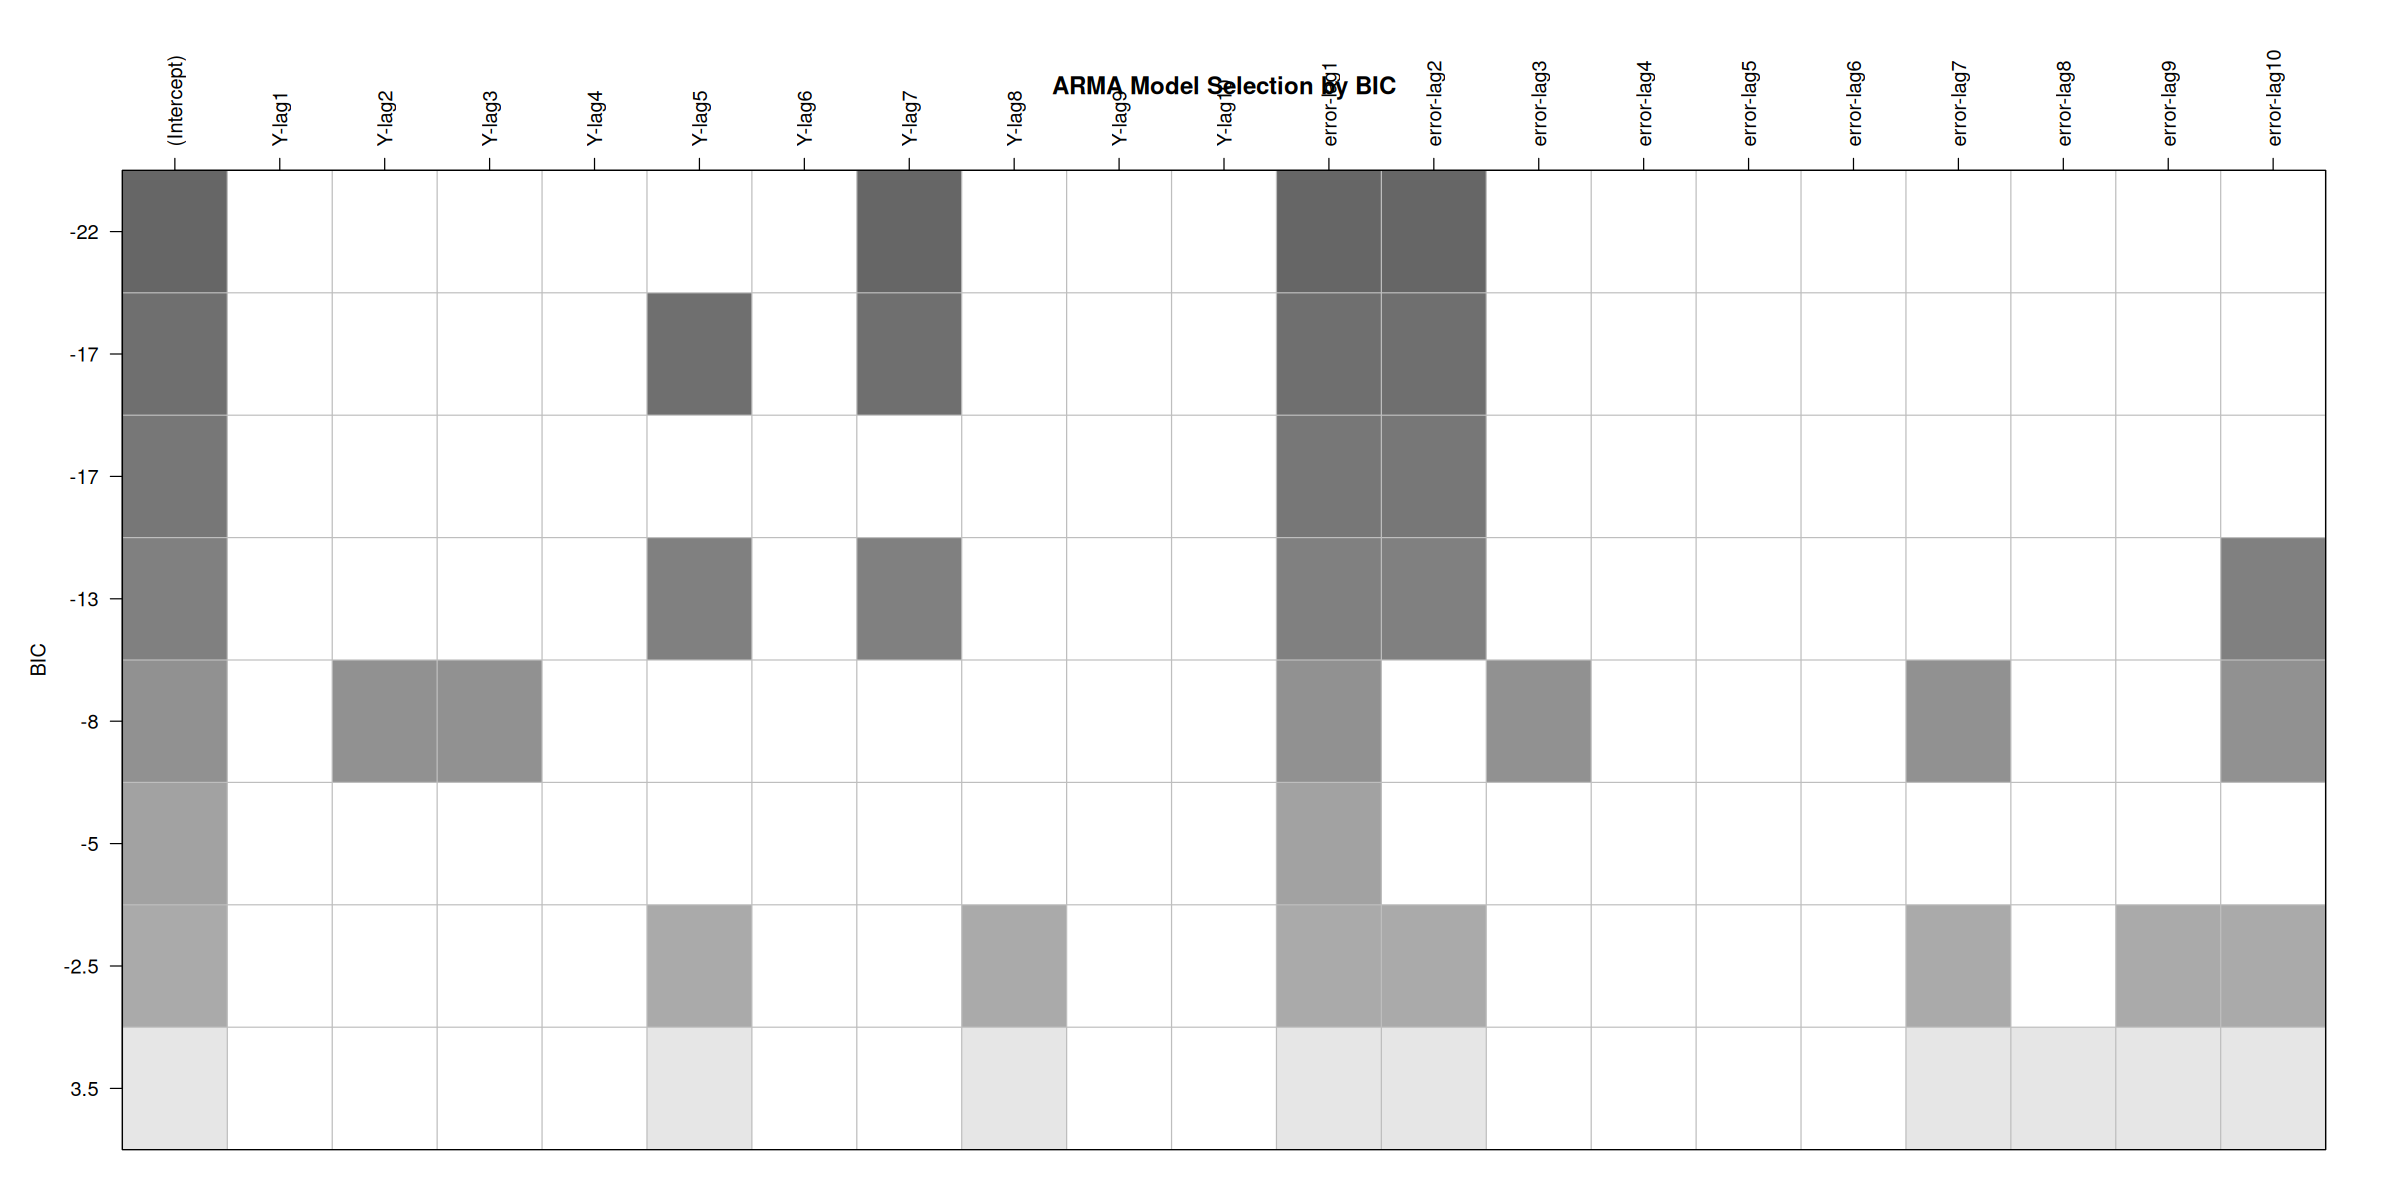

In [13]:
# Model identification using armasubsets
subset_results <- armasubsets(y = diff_ts, nar = 10, nma = 10,
                              ar.method = "ols")

# Plot results
par(bg = "white")
plot(subset_results, which = "bic", main = "ARMA Model Selection by BIC",
     xlab = "AR and MA terms", ylab = "BIC", cex.axis = 1, cex.lab = 1)

**Top 2 models using armasubsets() :**
- ARIMA(0,1,2)
- ARIMA(1,1,2)

In [14]:
# Grid search for best ARIMA models
max_p <- 10
max_q <- 10
d <- 1

aic_values <- matrix(NA, nrow = max_p + 1, ncol = max_q + 1)
bic_values <- matrix(NA, nrow = max_p + 1, ncol = max_q + 1)

cat("\nFitting ARIMA models with different orders...\n")
for (p in 0:max_p) {
  for (q in 0:max_q) {
    if (p == 0 && q == 0) next
    
    cat(sprintf("Fitting ARIMA(%d,%d,%d)...\n", p, d, q))
    
    tryCatch({
      # Using transformed_ts instead of monthly_ts
      model <- Arima(transformed_ts, order = c(p, d, q))
      aic_values[p+1, q+1] <- model$aic
      bic_values[p+1, q+1] <- model$bic
    }, error = function(e) {
      cat("  Error:", e$message, "\n")
    })
  }
}

model_data <- data.frame(
  p = rep(0:max_p, each = max_q + 1),
  q = rep(0:max_q, max_p + 1),
  AIC = as.vector(aic_values),
  BIC = as.vector(bic_values)
)

model_data <- model_data[!is.na(model_data$AIC) & !is.na(model_data$BIC), ]
model_data$Model <- paste0("(", model_data$p, ",1,", model_data$q, ")")

best_aic_model <- model_data[which.min(model_data$AIC), ]
best_bic_model <- model_data[which.min(model_data$BIC), ]

cat("\nBest model by AIC: ARIMA", best_aic_model$Model, "with AIC =", round(best_aic_model$AIC, 2), "\n")
cat("Best model by BIC: ARIMA", best_bic_model$Model, "with BIC =", round(best_bic_model$BIC, 2), "\n")


Fitting ARIMA models with different orders...
Fitting ARIMA(0,1,1)...
Fitting ARIMA(0,1,2)...
Fitting ARIMA(0,1,3)...
Fitting ARIMA(0,1,4)...
Fitting ARIMA(0,1,5)...
Fitting ARIMA(0,1,6)...
Fitting ARIMA(0,1,7)...
Fitting ARIMA(0,1,8)...
Fitting ARIMA(0,1,9)...
Fitting ARIMA(0,1,10)...
Fitting ARIMA(1,1,0)...
Fitting ARIMA(1,1,1)...
Fitting ARIMA(1,1,2)...
Fitting ARIMA(1,1,3)...
Fitting ARIMA(1,1,4)...
Fitting ARIMA(1,1,5)...
Fitting ARIMA(1,1,6)...
Fitting ARIMA(1,1,7)...
Fitting ARIMA(1,1,8)...
Fitting ARIMA(1,1,9)...
Fitting ARIMA(1,1,10)...
Fitting ARIMA(2,1,0)...
Fitting ARIMA(2,1,1)...
Fitting ARIMA(2,1,2)...
Fitting ARIMA(2,1,3)...
Fitting ARIMA(2,1,4)...
Fitting ARIMA(2,1,5)...
Fitting ARIMA(2,1,6)...
Fitting ARIMA(2,1,7)...
Fitting ARIMA(2,1,8)...
Fitting ARIMA(2,1,9)...
Fitting ARIMA(2,1,10)...
Fitting ARIMA(3,1,0)...
Fitting ARIMA(3,1,1)...
Fitting ARIMA(3,1,2)...
Fitting ARIMA(3,1,3)...
Fitting ARIMA(3,1,4)...
Fitting ARIMA(3,1,5)...
Fitting ARIMA(3,1,6)...
Fitting ARIMA(

**The best models using grid search are:**
- Best model by AIC: ARIMA (4,1,6) with AIC = 5010.92 
- Best model by BIC: ARIMA (0,1,2) with BIC = 5039.02 

In [15]:
# Split data for training and testing
n_months <- length(transformed_ts)
train_end <- n_months - 24  # Use last 24 months for testing

train_ts <- window(transformed_ts, end = c(time(transformed_ts)[train_end]))
test_ts <- window(transformed_ts, start = c(time(transformed_ts)[train_end + 1]))

# Define candidate models from both selection methods
candidate_models <- list(
  list(p=4, d=1, q=6, name="ARIMA(4,1,6) - Best AIC (Grid Search)"),
  list(p=0, d=1, q=2, name="ARIMA(0,1,2) - Best BIC (Grid Search) & Top ARMASUBSETS Model"),
  list(p=1, d=1, q=2, name="ARIMA(1,1,2) - Top ARMASUBSETS Model")
)

# Remove duplicates if any
unique_models <- list()
model_names <- character()
for (model in candidate_models) {
  model_key <- paste(model$p, model$d, model$q)
  if (!(model_key %in% names(unique_models))) {
    unique_models[[model_key]] <- model
    model_names <- c(model_names, model$name)
  }
}
candidate_models <- unique_models

# Fit models and evaluate forecasts
forecast_results <- data.frame(
  Model = character(),
  RMSE = numeric(),
  MAE = numeric(),
  MAPE = numeric(),
  stringsAsFactors = FALSE
)

fitted_models <- list()

for (model_key in names(candidate_models)) {
  model <- candidate_models[[model_key]]
  model_name <- model$name
  p <- model$p
  d <- model$d
  q <- model$q
  
  cat(sprintf("\nFitting %s...\n", model_name))
  
  tryCatch({
    # Fit model
    arima_model <- Arima(train_ts, order = c(p, d, q))
    fitted_models[[model_name]] <- arima_model
    
    # Generate forecasts
    h <- length(test_ts)
    forecasts <- forecast(arima_model, h = h)
    
    # Calculate error metrics
    errors <- test_ts - forecasts$mean
    rmse <- sqrt(mean(errors^2))
    mae <- mean(abs(errors))
    mape <- mean(abs(errors / test_ts)) * 100
    
    cat(sprintf("RMSE: %.4f, MAE: %.4f, MAPE: %.2f%%\n", rmse, mae, mape))
    
    # Add to results
    forecast_results <- rbind(forecast_results, data.frame(
      Model = model_name,
      RMSE = rmse,
      MAE = mae,
      MAPE = mape
    ))
    
  }, error = function(e) {
    cat("  Error:", e$message, "\n")
  })
}

# Sort by RMSE
forecast_results <- forecast_results[order(forecast_results$RMSE), ]
rownames(forecast_results) <- NULL

cat("\nOut-of-sample forecast accuracy comparison:\n")
print(forecast_results)

# Identify best model
best_model_name <- forecast_results$Model[1]
cat("\nBest model based on forecast accuracy (RMSE):", best_model_name, "\n")


Fitting ARIMA(4,1,6) - Best AIC (Grid Search)...
RMSE: 4.5703, MAE: 3.9934, MAPE: 4.82%

Fitting ARIMA(0,1,2) - Best BIC (Grid Search) & Top ARMASUBSETS Model...
RMSE: 4.7042, MAE: 4.1157, MAPE: 4.97%

Fitting ARIMA(1,1,2) - Top ARMASUBSETS Model...
RMSE: 4.7128, MAE: 4.1227, MAPE: 4.98%

Out-of-sample forecast accuracy comparison:
                                                          Model     RMSE
1                         ARIMA(4,1,6) - Best AIC (Grid Search) 4.570312
2 ARIMA(0,1,2) - Best BIC (Grid Search) & Top ARMASUBSETS Model 4.704242
3                          ARIMA(1,1,2) - Top ARMASUBSETS Model 4.712759
       MAE     MAPE
1 3.993369 4.823963
2 4.115674 4.971606
3 4.122750 4.980240

Best model based on forecast accuracy (RMSE): ARIMA(4,1,6) - Best AIC (Grid Search) 



	Ljung-Box test

data:  Residuals from ARIMA(4,1,6)
Q* = 29.051, df = 14, p-value = 0.01029

Model df: 10.   Total lags used: 24



Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.


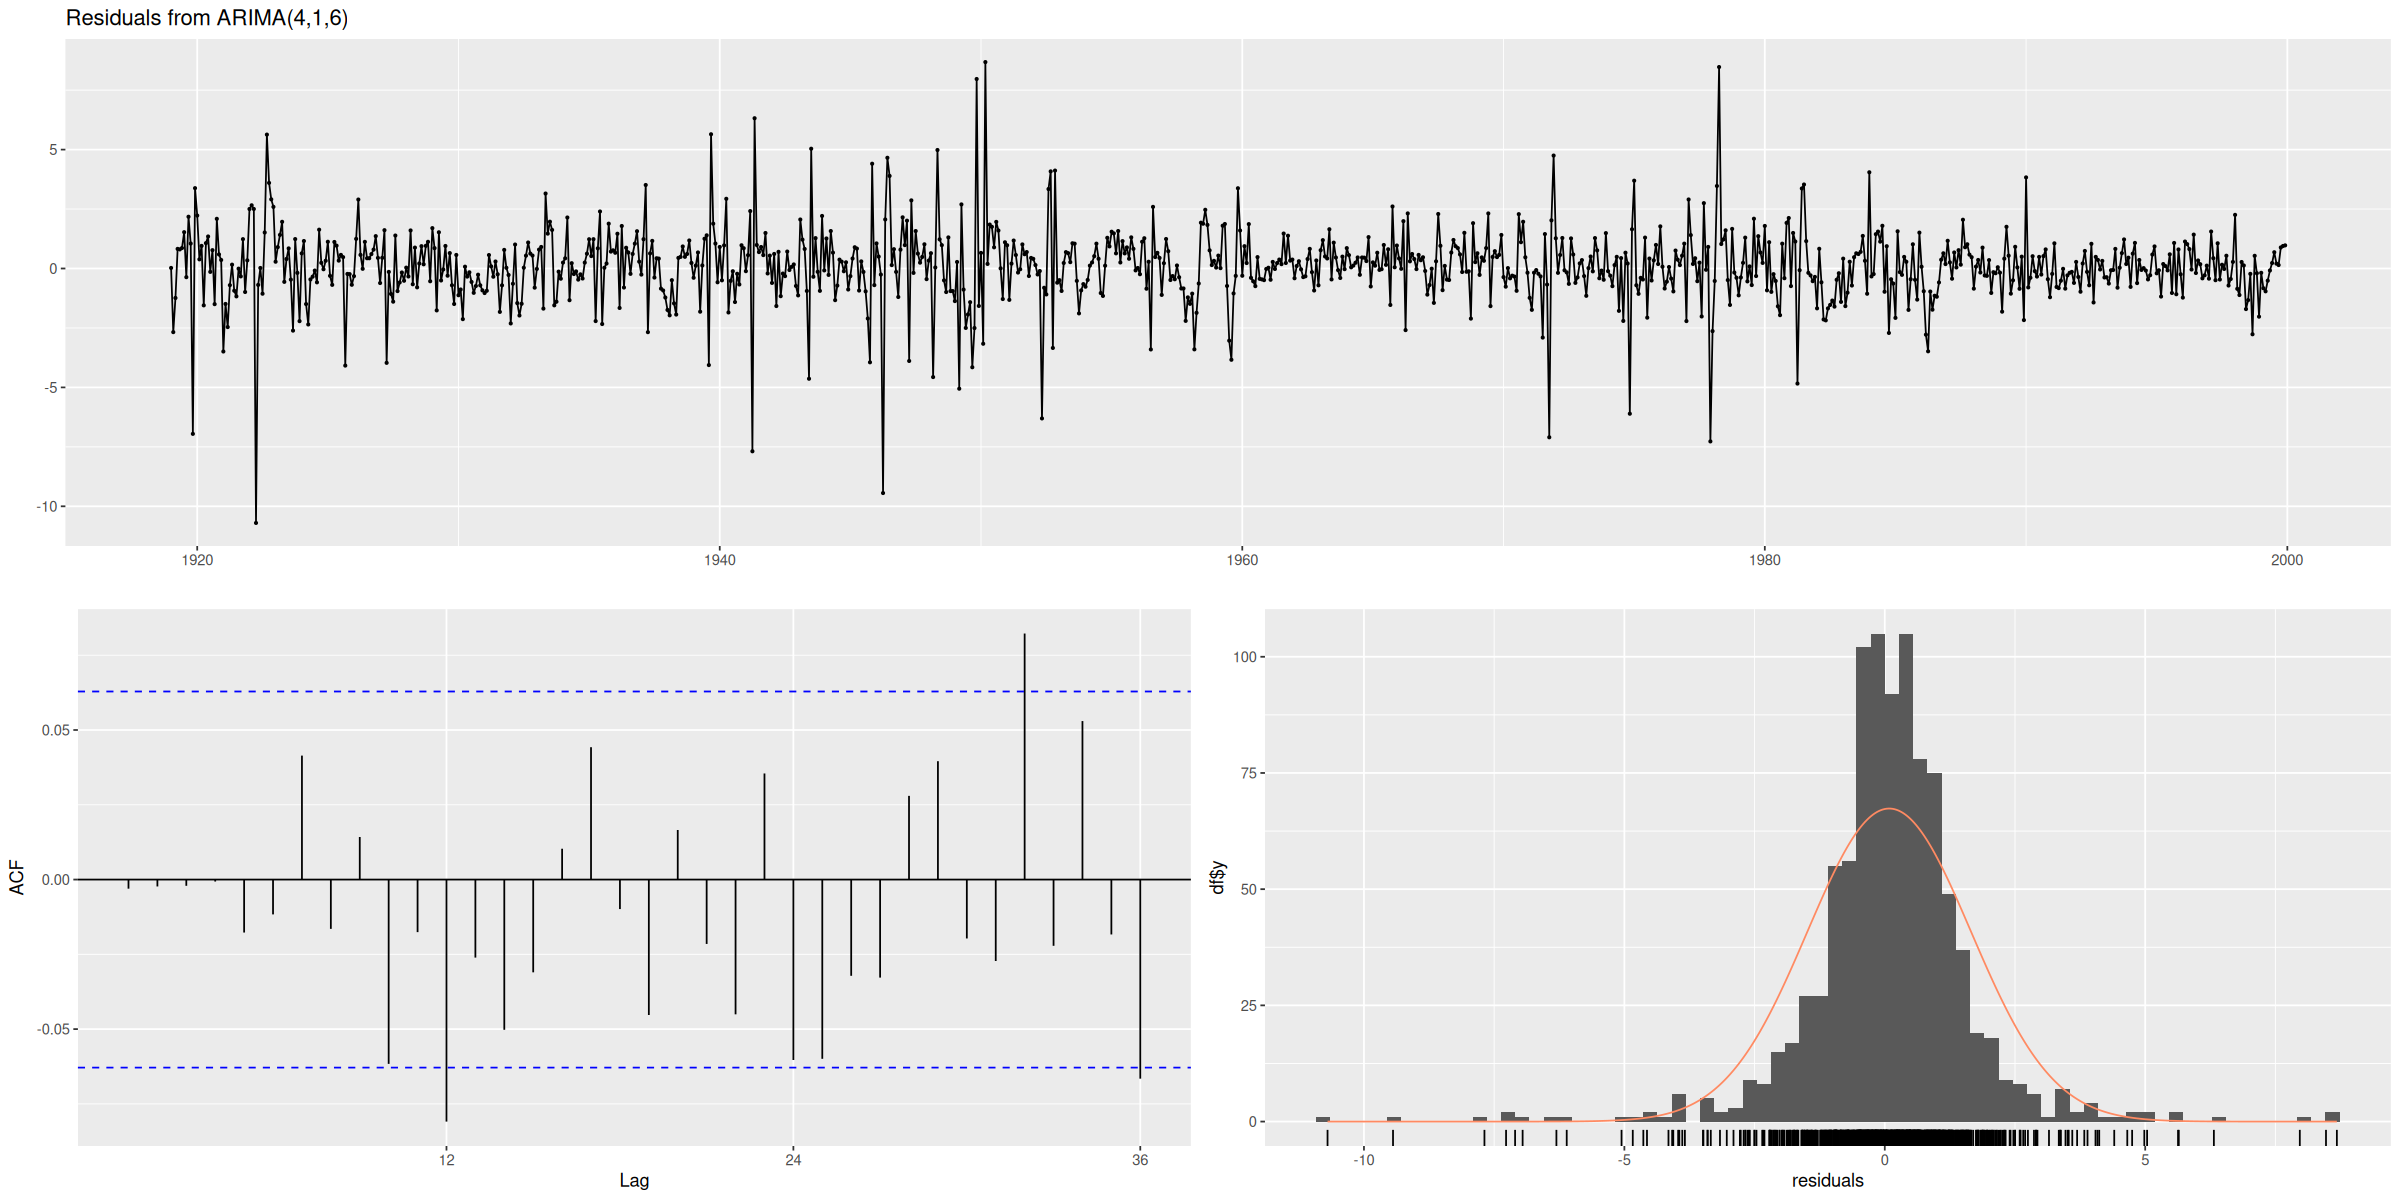


Shapiro-Wilk test for normality:

	Shapiro-Wilk normality test

data:  residuals(final_model)
W = 0.88742, p-value < 2.2e-16

Interpretation: p-value < 0.05, residuals not normally distributed 

Ljung-Box test for autocorrelation:

	Box-Ljung test

data:  residuals(final_model)
X-squared = 13.107, df = 12, p-value = 0.3613

Interpretation: p-value > 0.05, no significant autocorrelation remains 

ARCH test for conditional heteroskedasticity:

	ARCH LM-test; Null hypothesis: no ARCH effects

data:  residuals(final_model)
Chi-squared = 38.744, df = 12, p-value = 0.000116

Interpretation: p-value < 0.05, ARCH effects present 

Runs test for randomness:

	Runs Test - Two sided

data:  residuals(final_model) > 0
Standardized Runs Statistic = -Inf, p-value < 2.2e-16

Interpretation: p-value < 0.05, residuals may not be random 


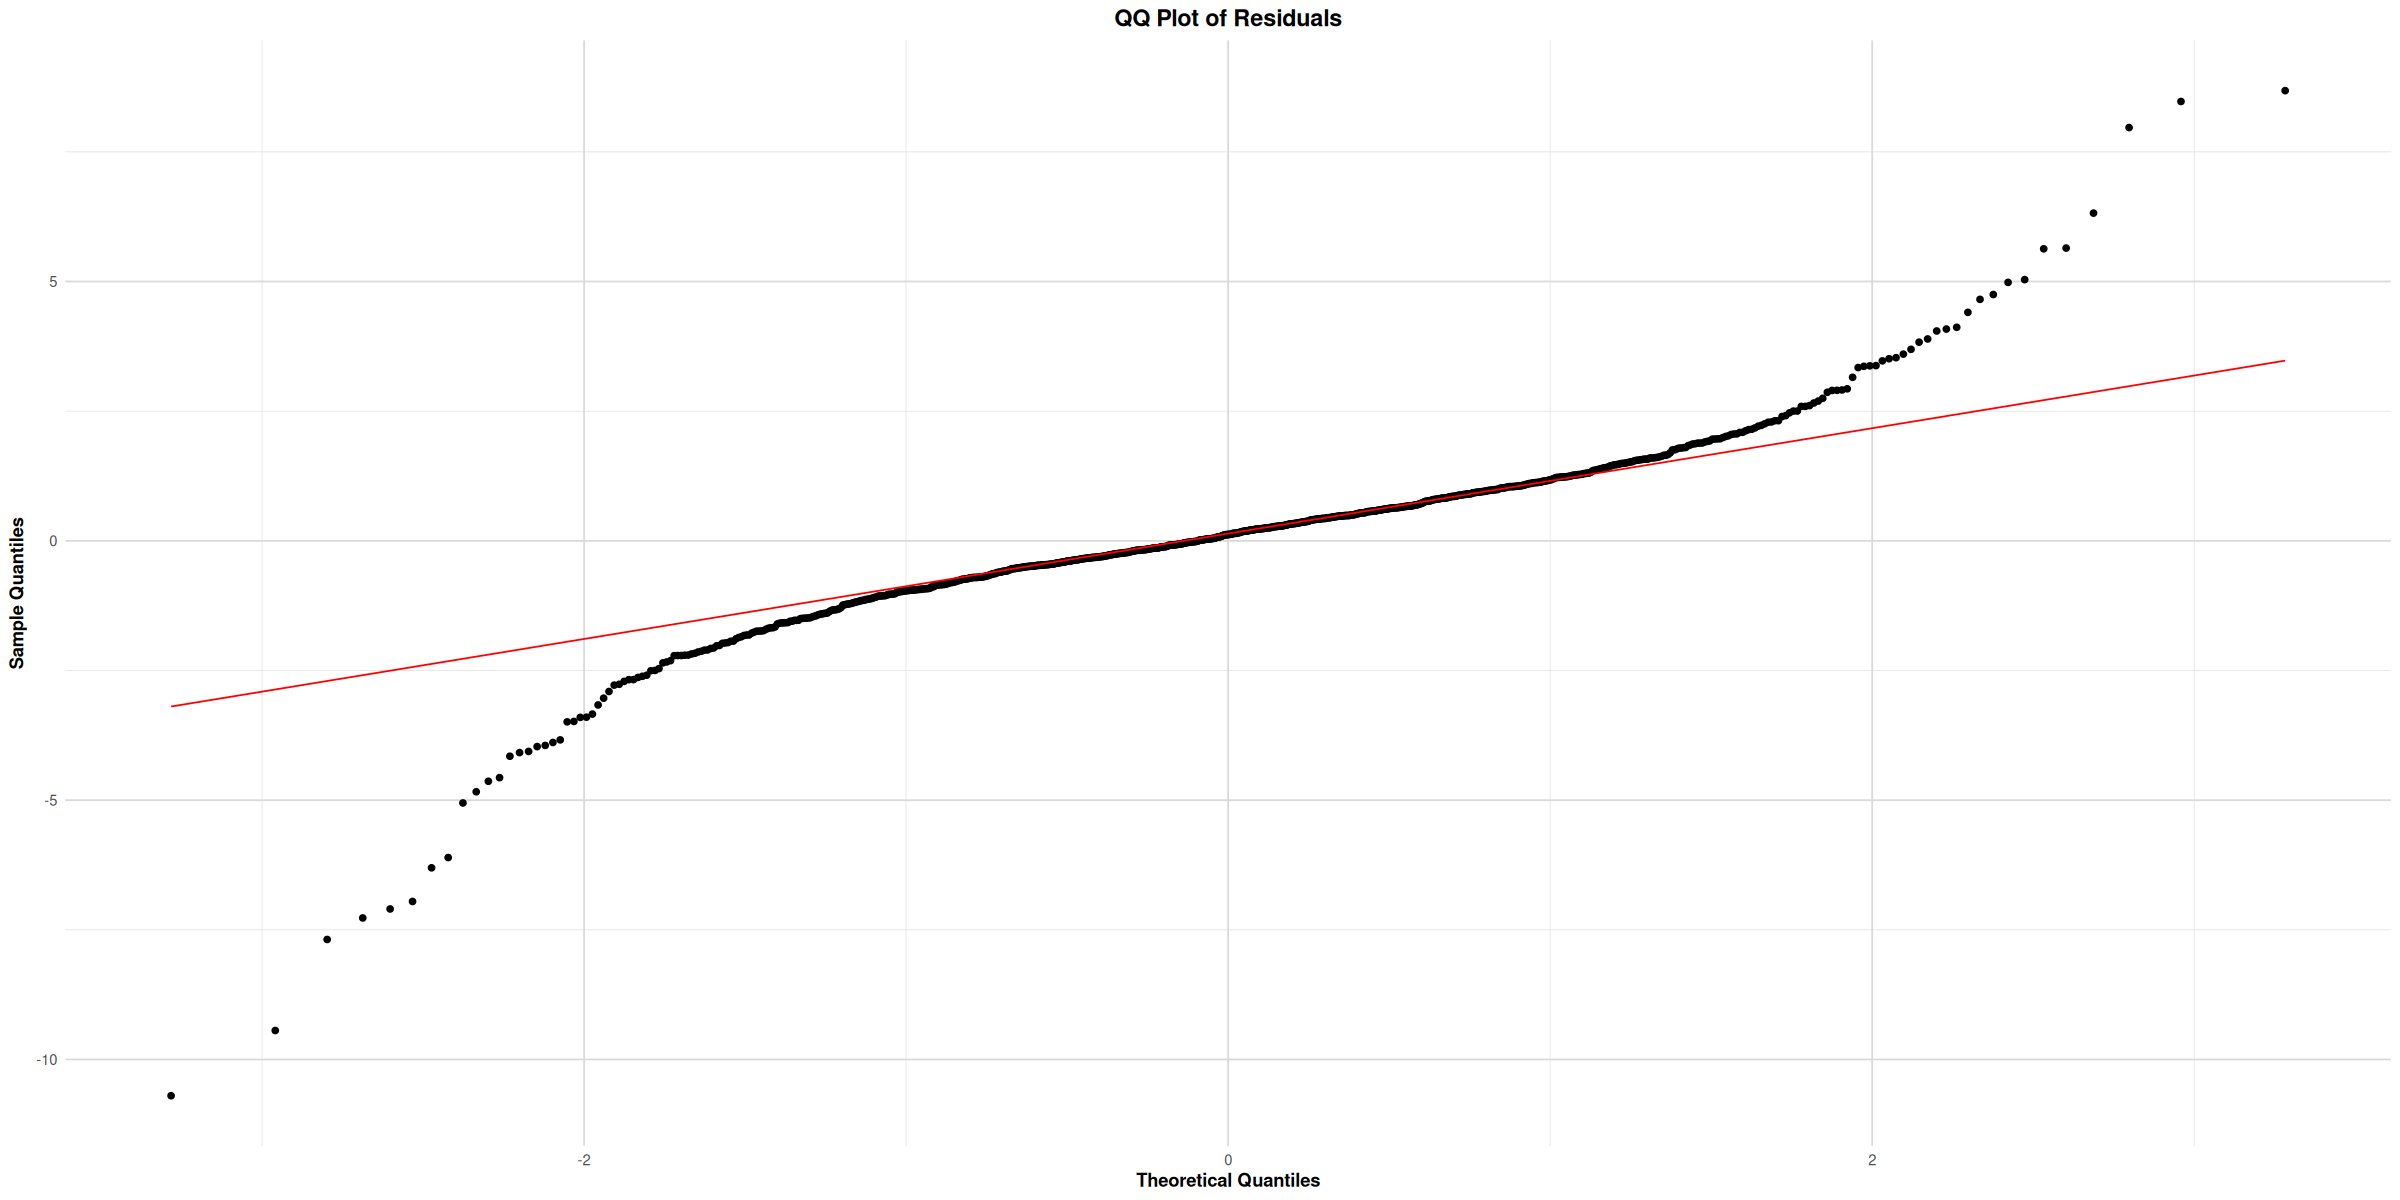

In [16]:
# Refit best model on full transformed data
# Check if best_model_name exists first
if (exists("best_model_name") && !is.null(best_model_name)) {
  p <- as.numeric(gsub(".*\\(([0-9]+),1,([0-9]+).*", "\\1", best_model_name))
  q <- as.numeric(gsub(".*\\(([0-9]+),1,([0-9]+).*", "\\2", best_model_name))
} else {
  # Use ARIMA(1,1,1) as default model if best_model_name isn't defined
  p <- 1
  q <- 1
  best_model_name <- "ARIMA(1,1,1) - Default"
  cat("No best model name found, using default ARIMA(1,1,1)\n")
}

final_model <- Arima(transformed_ts, order = c(p, 1, q))

# Check residuals
checkresiduals(final_model)

# Plot residuals using mining_df instead of power_df
residuals_df <- data.frame(
  Date = mining_df$date[(length(mining_df$date) - length(residuals(final_model)) + 1):length(mining_df$date)],
  Residuals = residuals(final_model)
)

# qq plot
p_qq <- ggplot(residuals_df, aes(sample = Residuals)) +
  stat_qq() +
  stat_qq_line(color = "red") +
  labs(
    title = "QQ Plot of Residuals",
    x = "Theoretical Quantiles",
    y = "Sample Quantiles"
  ) +
  theme_tsa()
print(p_qq)

# Normality test
shapiro_test <- shapiro.test(residuals(final_model))
cat("\nShapiro-Wilk test for normality:\n")
print(shapiro_test)
cat("Interpretation: p-value", ifelse(shapiro_test$p.value > 0.05, 
    "> 0.05, residuals appear normally distributed", 
    "< 0.05, residuals not normally distributed"), "\n")

# Ljung-Box test for autocorrelation
lb_test <- Box.test(residuals(final_model), lag = 12, type = "Ljung-Box")
cat("\nLjung-Box test for autocorrelation:\n")
print(lb_test)
cat("Interpretation: p-value", ifelse(lb_test$p.value > 0.05, 
    "> 0.05, no significant autocorrelation remains", 
    "< 0.05, significant autocorrelation remains"), "\n")

# ARCH test for heteroskedasticity
arch_test <- ArchTest(residuals(final_model), lags = 12)
cat("\nARCH test for conditional heteroskedasticity:\n")
print(arch_test)
cat("Interpretation: p-value", ifelse(arch_test$p.value > 0.05, 
    "> 0.05, no significant ARCH effects detected", 
    "< 0.05, ARCH effects present"), "\n")

# Runs test for randomness
runs_test <- runs.test(residuals(final_model) > 0)
cat("\nRuns test for randomness:\n")
print(runs_test)
cat("Interpretation: p-value", ifelse(runs_test$p.value > 0.05, 
    "> 0.05, residuals appear random", 
    "< 0.05, residuals may not be random"), "\n")